In [55]:
# | hidden: true
# | echo: false
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# some personal style settings to make the plots look nice
# and save some space in the notebook
plt.style.use("../style.mplstyle")

## Confidence Intervals

We have talked about quantifying uncertainty with $p$-values (the probability of observing the data under a some hypothesis). But oftentimes we want to quantify uncertainty in a different way: by estimating the range of values that some parameter is likely to take. So, rather than asking "how likely is it that the average is $\mu=0$?" we might ask "what is a plausible range of values for the average?"

This range is called a **confidence interval**. Like in hypothesis testing, we can choose a risk level $\alpha$ (e.g., 5%). 
The confidence interval, like a hypothesis test, is computed based on a sample -- so sometimes it is incorrect! 

Mathematically, we the confidence interval for a parameter $\theta$ is defined as the range of values bounded by $[L, U]$ that are likely to contain the true value of the parameter with probability $1-\alpha$:
$$
\mathbb{P}(\theta \in [L, U]) = 1 - \alpha
$$

There is an important distinction to make here: $\theta$ is not the thing that changes! In fact, we can't compute $\theta$ - it is a theoretical property of the population, which we can't access in its entirety. What changes is the sample we draw from the population, and the confidence interval is computed based on that sample. So, if we draw a different sample, we will get a different confidence interval.

### Confidence Intervals when the distribution is known
Think back to the Central Limit Theorem (CLT). The CLT tells us that the distribution of the sample mean is roughly normal. From this, we know 3 important things:

1. The sample mean $\bar{X}$ is an unbiased estimator of the population mean $\mu$. Meaning, we can assume that the sample mean is typically close to the population mean.
2. The variance of the sample mean is $\sigma^2/n$, where $\sigma^2$ can be estimated from the sample.
3. The distribution of the sample mean is symmetric.


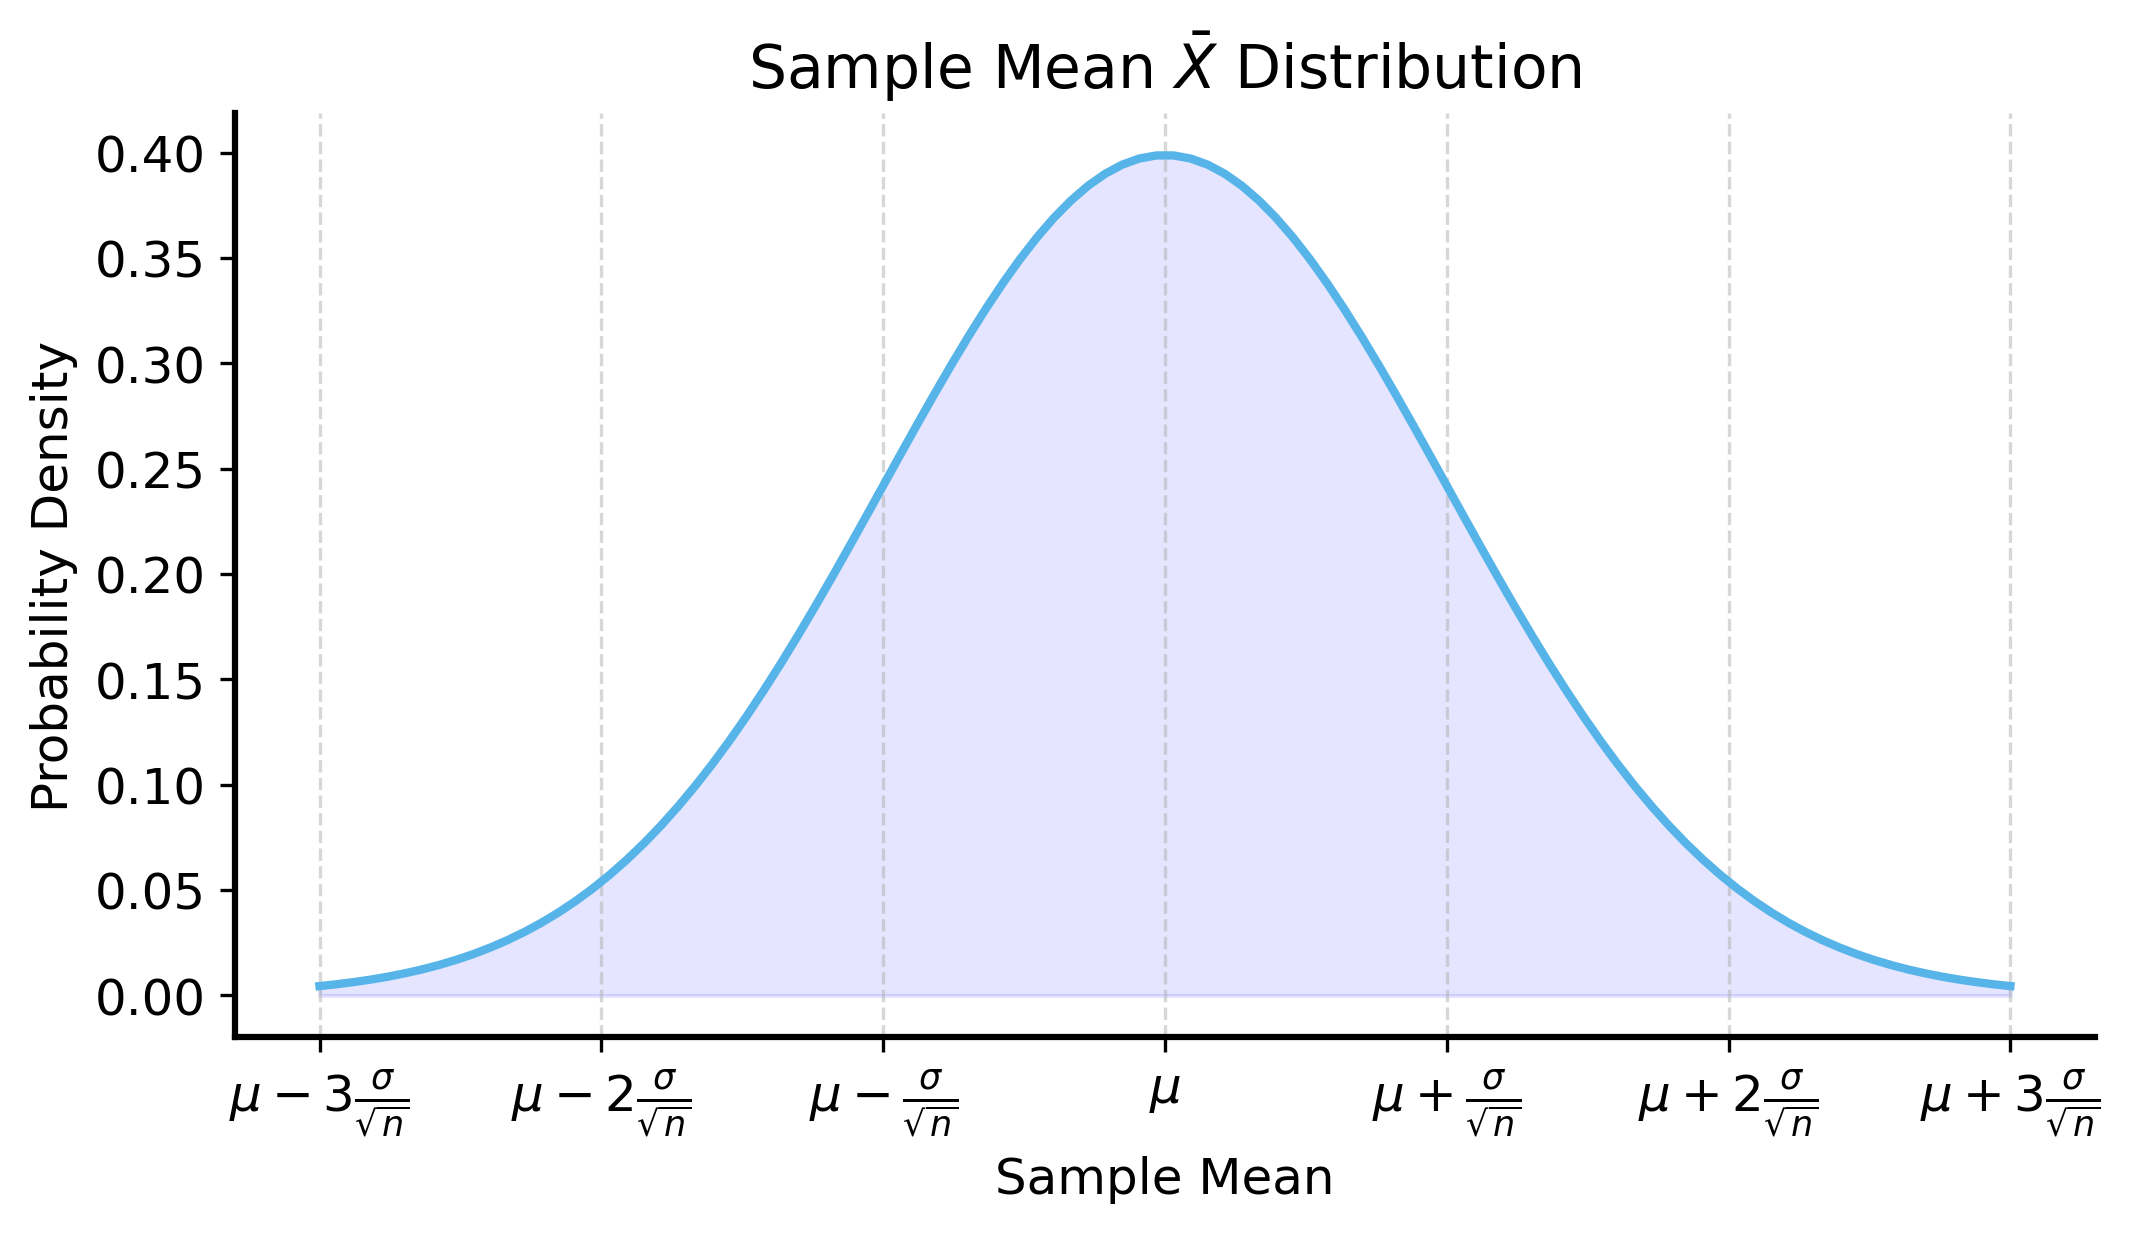

In [ ]:
# annotated plot of the sample mean distribution
fix, ax = plt.subplots(figsize=(8, 4))
x = np.linspace(-3, 3, 100)
pdf = stats.norm.pdf(x, loc=0, scale=1)
ax.plot(x, pdf, label="Sample Mean Distribution")
ax.fill_between(x, pdf, alpha=0.1, color="blue")
# ax.axvline(0, color="black", linestyle="--")
# ax.axvline([1, -1], color="red", linestyle="--", label=r"$\mu \pm \frac{\sigma}{\sqrt{n}}$")
# ax.annotate(r"$\mu$", xy=(0, 0.1), xytext=(0.5, 0.2),
#             arrowprops=dict(arrowstyle="->", color="black"),
#             fontsize=18, color="black")
ax.set_title(r"Sample Mean $\bar{X}$ Distribution")
ax.set_xlabel("Sample Mean")
ax.set_ylabel("Probability Density")
ax.set_xticks(np.arange(-3, 4, 1))
ax.set_xticklabels([r"$\mu-3\frac{\sigma}{\sqrt{n}}$", r"$\mu-2\frac{\sigma}{\sqrt{n}}$",
                    r"$\mu-\frac{\sigma}{\sqrt{n}}$", r"$\mu$", r"$\mu+\frac{\sigma}{\sqrt{n}}$",
                    r"$\mu+2\frac{\sigma}{\sqrt{n}}$", r"$\mu+3\frac{\sigma}{\sqrt{n}}$"])
ax.grid(True, linestyle="--", axis='x', alpha=0.5)
plt.show()


See that for a normal distribution, much of the probability mass is concentrated around the mean within a few standard deviations. How much probability mass is concentrated within $k$ standard deviations of the mean? 

Recall that when the distribution is known, we can compute the probability of the sample mean being in a certain range by integrating the probability density function (PDF). So for a normal distribution, we can compute the probability of the sample mean being in the range $[\mu - z\sigma/\sqrt{n}, \mu + z\sigma/\sqrt{n}]$ as:
$$
\begin{align*}
\mathbb{P}(\mu - z\sigma/\sqrt{n} \leq \bar{X} \leq \mu + z\sigma/\sqrt{n}) &= \int_{\mu - z\sigma/\sqrt{n}}^{\mu + z\sigma/\sqrt{n}} \frac{1}{\sqrt{2\pi\sigma^2/n}} e^{-\frac{(x - \mu)^2}{2\sigma^2/n}} \, dx \\
&= \int_{-z}^{z} \frac{1}{\sqrt{2\pi}} e^{-\frac{u^2}{2}} \, du
\end{align*}
$$
where we made the substitution $u = (x - \mu) \sqrt{n}/\sigma$. 

We can set this integral to be equal to the probability $1 - \alpha$ to find the value of $z$ that corresponds to a given confidence level. 

$$
\int_{-z}^{z} \frac{1}{\sqrt{2\pi}} e^{-\frac{u^2}{2}} \, du = 1 - \alpha
$$

Solving this integral for a chosen value of $\alpha$ gives us the value of $z$ that corresponds to that confidence level. We denote it as $z_{\alpha/2}$, because the upper limit corresponds to the $(1 - \frac{\alpha}{2})$ quantile of the distribution.

::: {.callout-note title="Standard normal distribution quantiles" collapse="true"}
The **standard normal** distribution is a normal distribution with mean 0 and standard deviation 1. See how after the substitution, the integrand is the PDF of the standard normal distribution. So $(1 - \alpha)$ is the probability that a sample from the standard normal distribution falls within $[-z, z]$.

This is the $(1 - \frac{\alpha}{2})$ because the standard normal distribution is symmetric around 0. So the probability $\alpha$ of the sample falling outside of $[-z, z]$ is split equally between the two tails of the distribution. So there is a probability of $\frac{\alpha}{2}$ of the sample falling below $-z$ and a probability of $\frac{\alpha}{2}$ of the sample falling above $z$.
:::

If you evaluate this integral, you find that the probability of the sample mean being within $z$ standard errors ^[i.e. the standard deviation of the sampling distribution] of the mean is, for various values of $z$:

| $z$ | Probability |
|-----|-------------|
| 1   | 0.6827      |
| 2   | 0.9545      |
| 3   | 0.9973      |
| 4   | > 0.9999    |

We use this logic to define a confidence interval for the population mean $\mu$ as:
$$
\begin{align*}
\left[\bar{X} - z_{\alpha/2}\frac{\sigma}{\sqrt{n}}, \bar{X} + z_{\alpha/2}\frac{\sigma}{\sqrt{n}}\right]
\end{align*}
$$



## Uncertainty without models

So far, we've emphasized the importance of developing **models** of data-generating processes in order to quantify randomness and uncertainty. If you know something about the underlying process that generates your data, you can pick an appropriate statistical model and use it to sample from the distribution, simulate new data, and evaluate hypotheses. The CLT is a powerful tool because even when we don't know what a good model of the data-generating process is, we can often use the normal distribution as an approximation for the distribution of sample means.

However, there are still many situations where we don't know enough about the DGP to confidently specify a model. In these cases, we can still use statistical techniques to evaluate hypotheses about the data. The idea is that if we don't have any knowledge about the DGP, we rely on the only information we have: the data itself. 

### Resampling methods

How did we get a dataset in the first place? Recall that every dataset is a sample from some underlying distribution.

What is the main difference between a sample and a population? A sample is a subset of the population, and it is usually much smaller than the population. The sample might not cover all the "edge cases" or rare events that are present in the population, or certain outcomes might be overrepresented (you *could* flip a fair coin 10 times and get 10 heads, even if it is unlikely). But as we have seen, the bigger the sample is the more it tends to represent the population well.

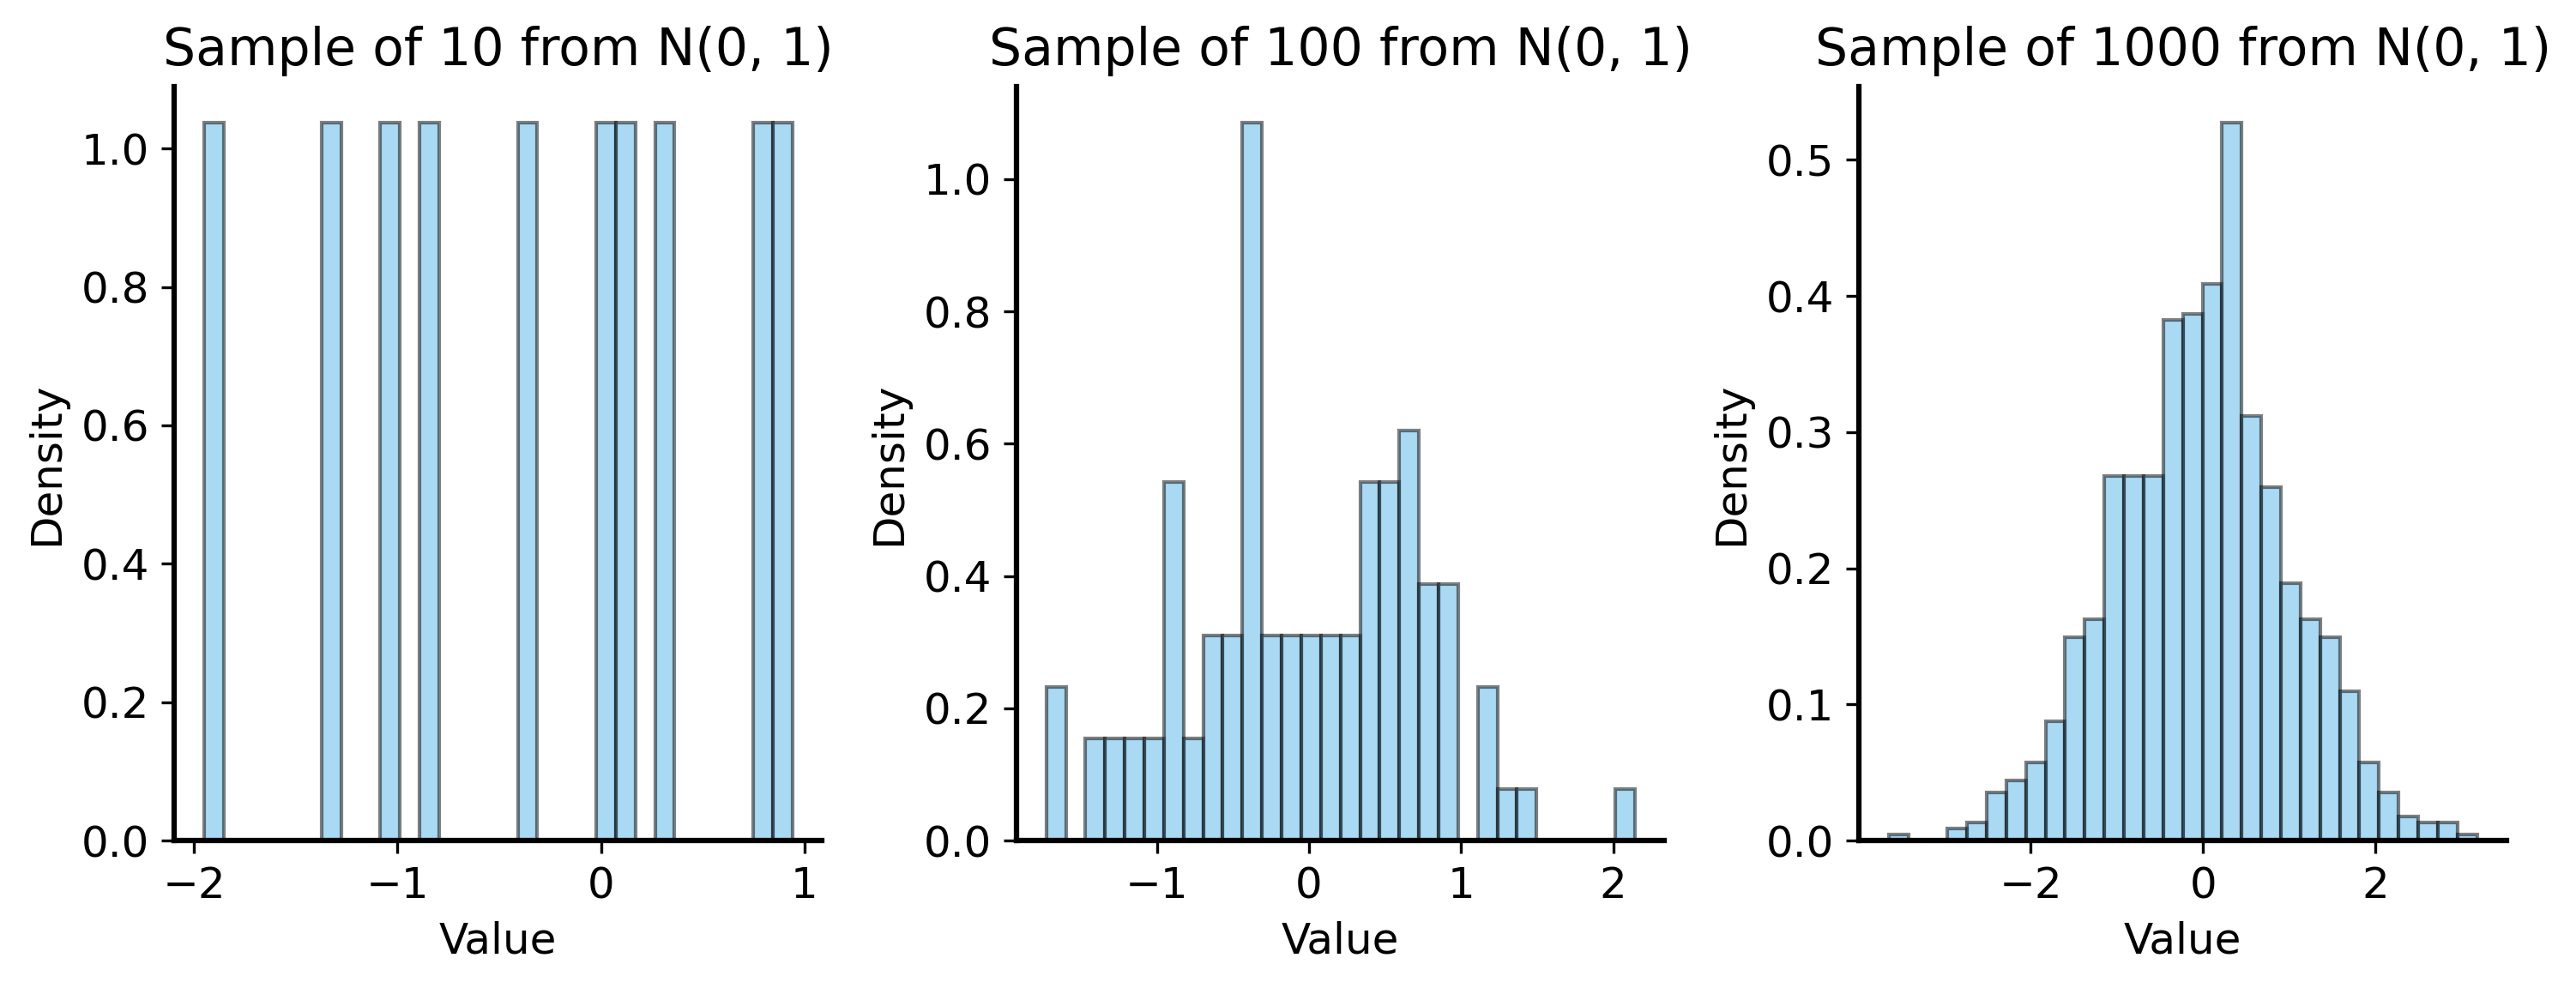

In [24]:
# sample data from a normal distribution
rng = np.random.default_rng(42)  # for reproducibility
fig, ax = plt.subplots(1, 3, figsize=(10, 4))
for i, n_samples in enumerate([10, 100, 1000]):
    sample = rng.normal(loc=0, scale=1, size=n_samples)
    ax[i].hist(sample, bins=30, density=True, alpha=0.5)
    ax[i].set_title(f"Sample of {n_samples} from N(0, 1)")
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Density")
plt.tight_layout()
plt.show()

If the sample starts to look like the population... then maybe we can just use the sample itself as a proxy for the population? This is the idea behind **resampling methods**. When the sample is pretty large, we can **sub-sample** from the original dataset as though it were the population, and use the sub-samples to estimate properties of the population.

Let's try this with the example above. Treating each of the histograms as a proxy for the population, we will sub-sample (with replacement) from the sample 1000 times to create new samples, and see what they look like.

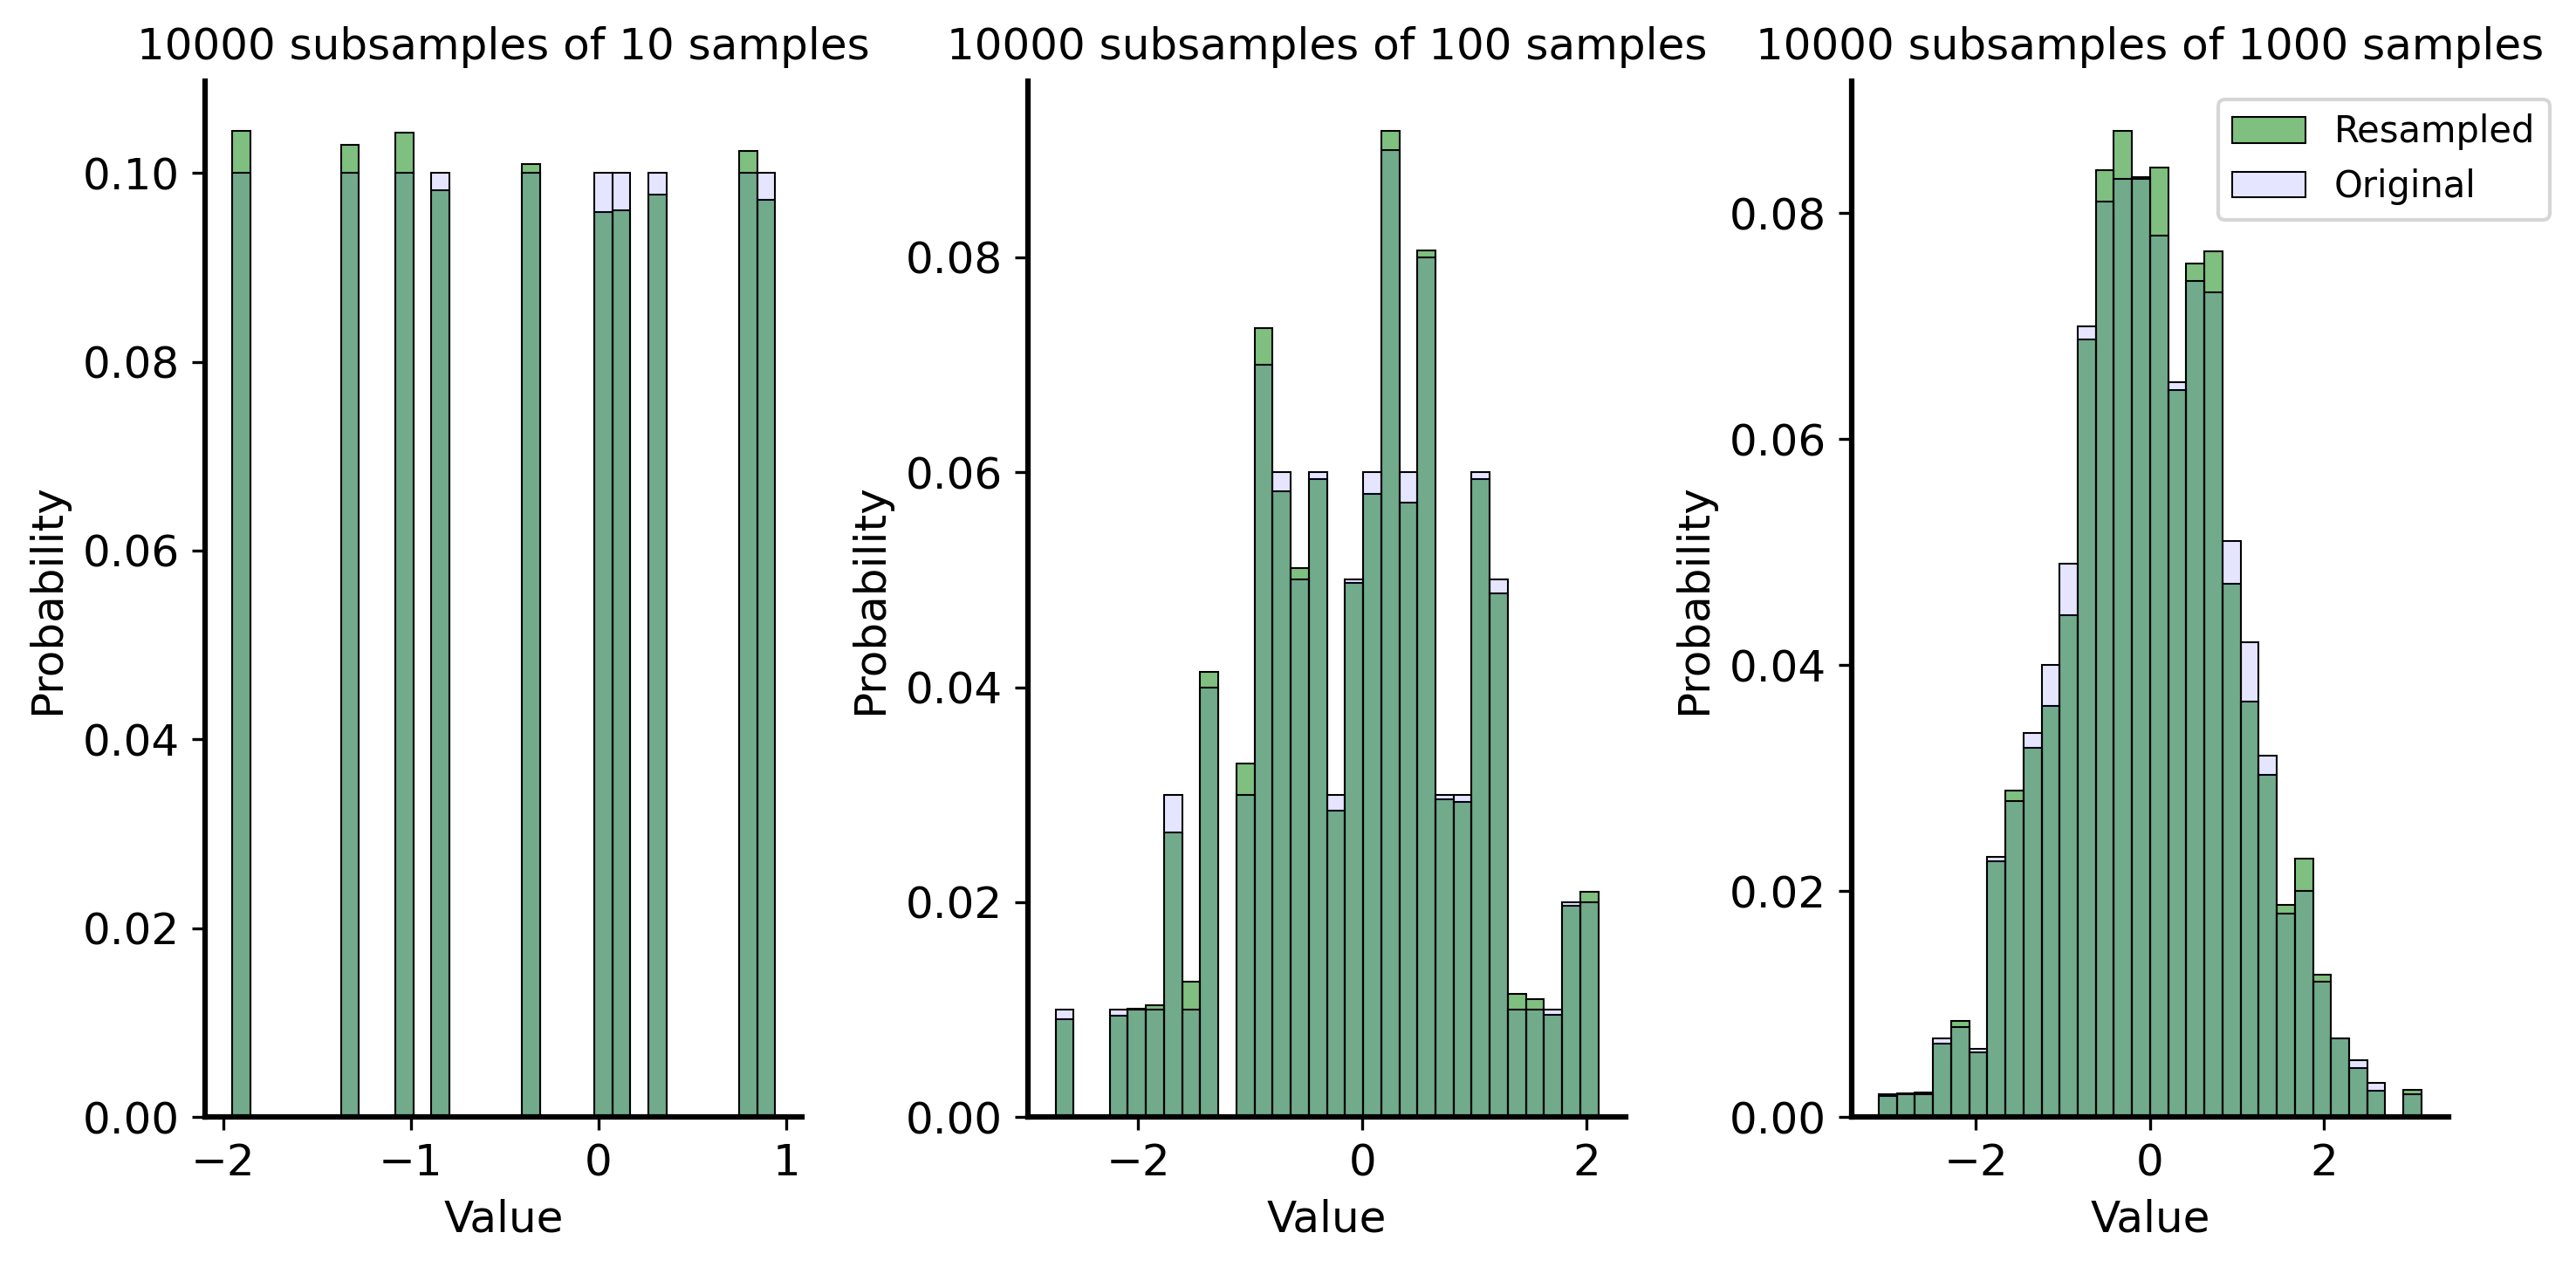

In [25]:
rng = np.random.default_rng(42)  # for reproducibility
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
for i, n_samples in enumerate([10, 100, 1000]):
    sample = rng.normal(loc=0, scale=1, size=n_samples)
    # choose samples at random with replacement
    resample = rng.choice(sample, size=10000, replace=True)
    sns.histplot(resample, bins=30, stat="probability", alpha=0.5, color='green', label='Resampled', ax=ax[i])
    sns.histplot(sample, bins=30, stat="probability", alpha=0.1, color='blue', label='Original', ax=ax[i])
    ax[i].set_title(f"10000 subsamples of {n_samples} samples", fontsize=12)
    ax[i].set_xlabel("Value")
    ax[i].set_ylabel("Probability")
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
plt.tight_layout()
plt.show()

As it turns out, the distribution of the resampled data is very similar to the original sample. So if the original sample is similar to the true population distribution, the resampled distribution will retain that similarity. 

## Bootstrapping
Bootstrapping is a specific type of resampling method that allows us to estimate the sampling distribution of any test statistic (e.g., mean, median, variance) by repeatedly resampling with replacement from the observed data. This bootstrapped distribution can then be used to compute confidence intervals or perform hypothesis tests without making *any* assumptions about the underlying distribution of the data! 

Bootstrapping works as follows:

1. Given a dataset of size $n$, draw a sample of size $n$ from the original dataset with replacement.
2. Compute the test statistic (e.g., mean, median, variance) on the bootstrapped sample.
3. Repeat steps 1 and 2 a large number of times (e.g., 1000 times) to create a distribution of the test statistic.
4. Use the distribution of the test statistic to compute confidence intervals or perform hypothesis tests.

::: {.callout-note title="Why sample with replacement?" collapse=true}
The idea behind the bootstrap is to take *independent* samples from the original dataset. It is supposed to simulate i.i.d. sampling from the population. Sampling with replacement allows us to create new samples such that taking a sample does not affect the next sample, and every bootstrapped sample comes from the same proxy distribution.

Think about what would happen if we sampled without replacement: since the sample is the same size as the original dataset, we would end up with the same sample every time! There are only $n$ datapoints in the sample, so if we sample without replacement, we will always get the same sample back. 
:::

Let's generate a sample from a normal distribution with known parameters $\mu=3.2$ and $\sigma=1.5$. 
Then, we will use bootstrapping to estimate the mean and variance of the population from the sample.

Bootstrapped mean: 3.16
Bootstrapped standard deviation: 1.48


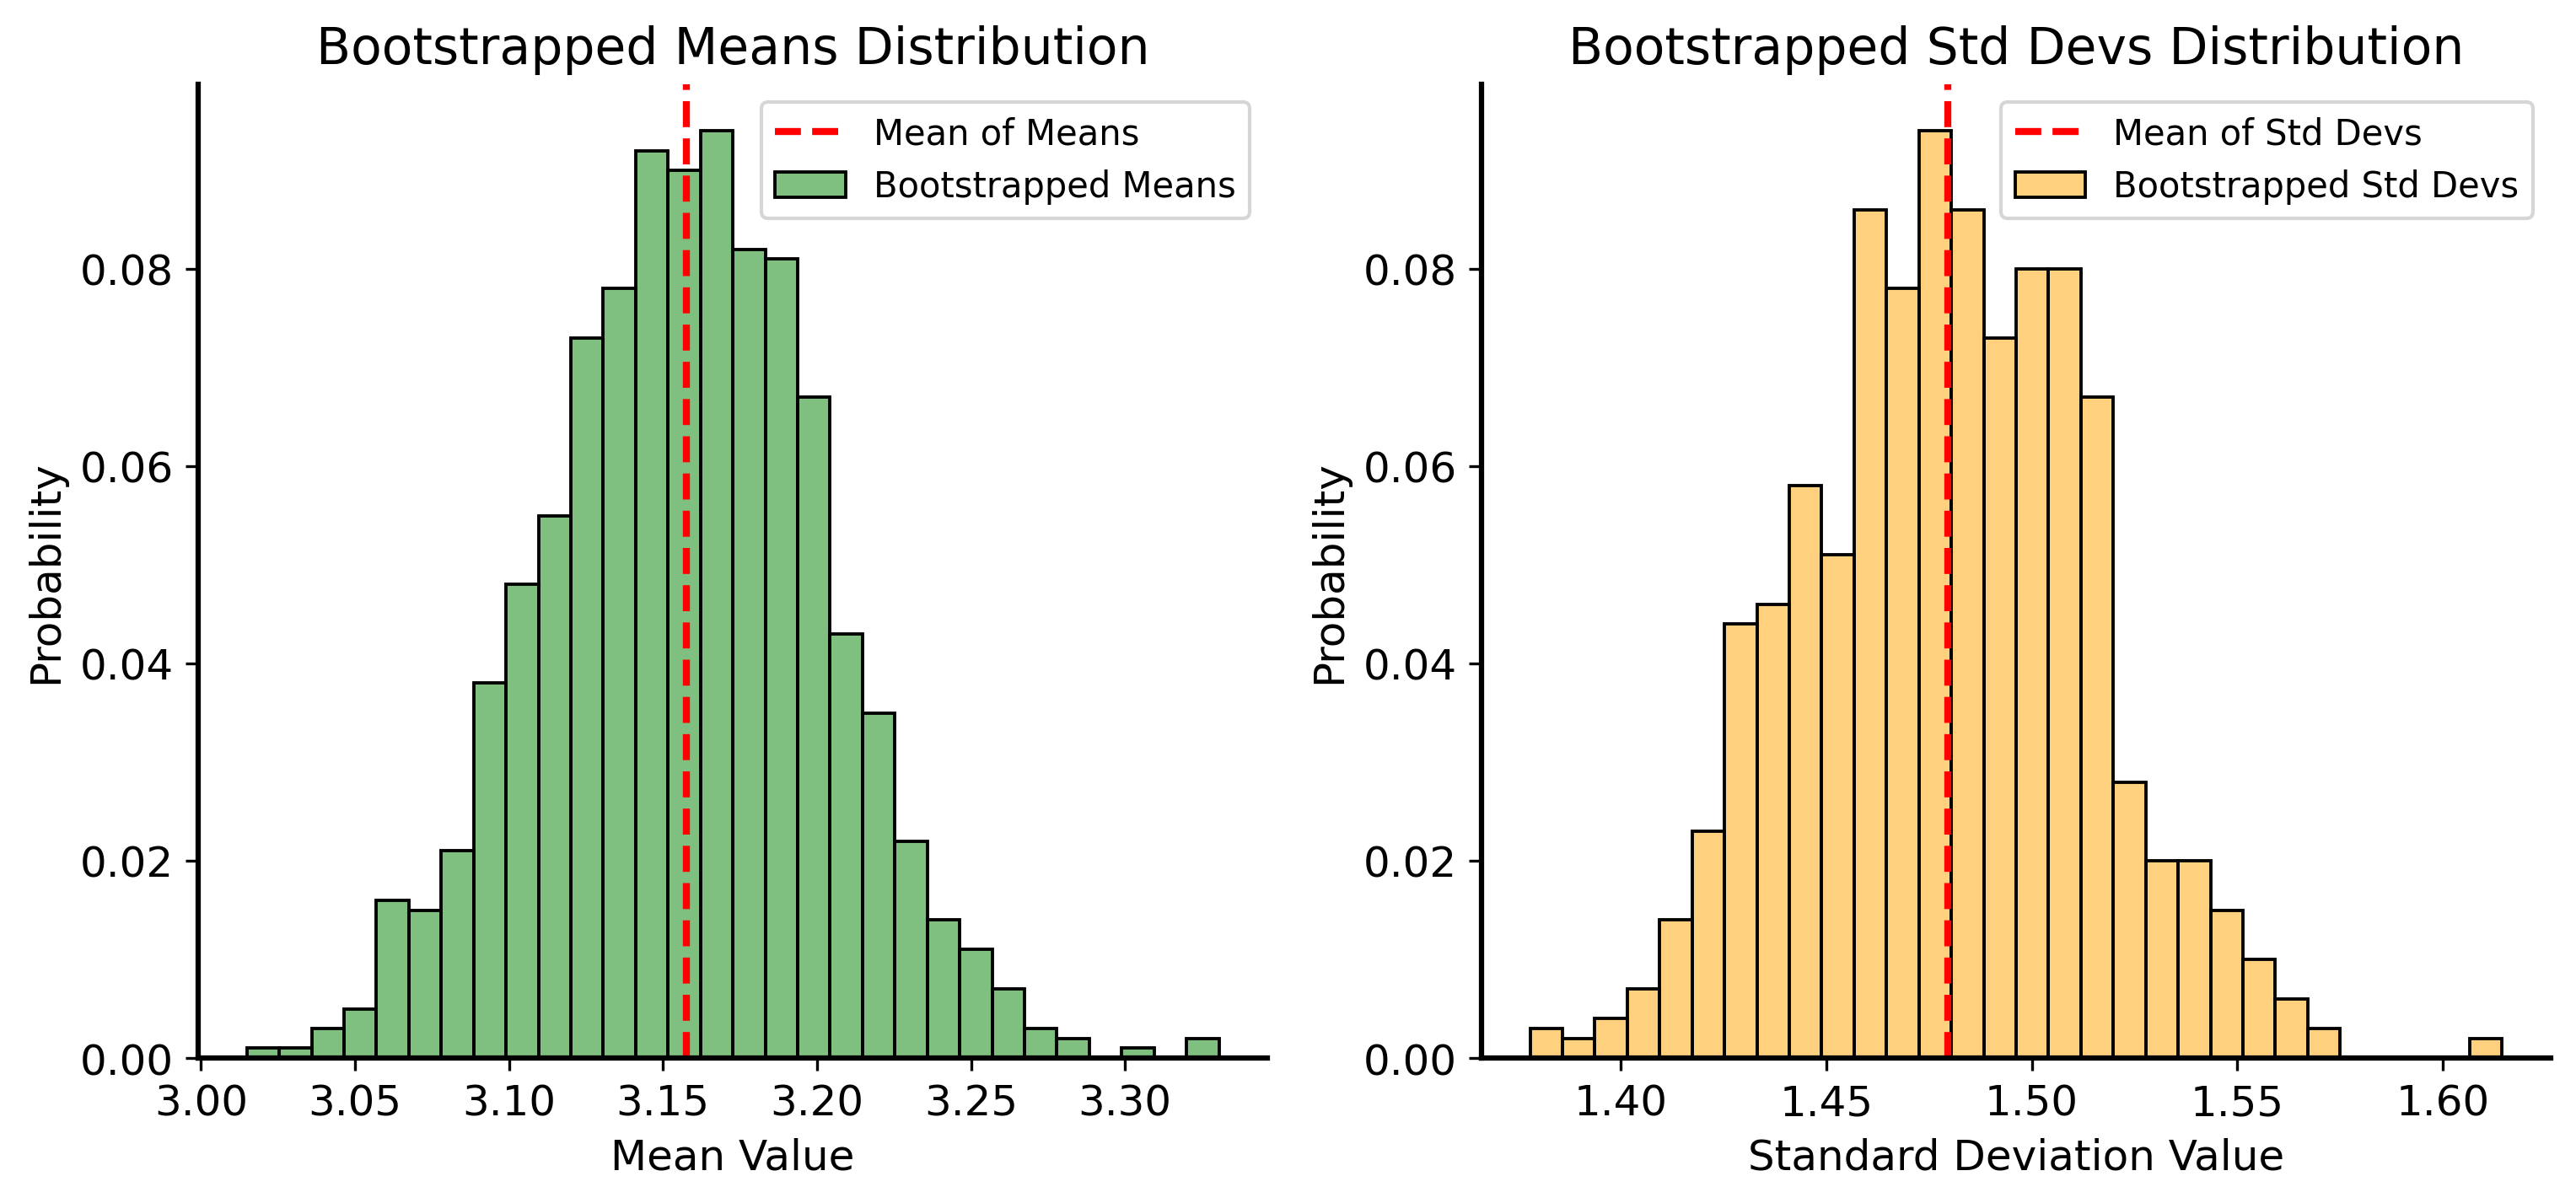

In [33]:
rng = np.random.default_rng(42)

sample_size = 1000
n_bootstraps = 1000

original_sample = rng.normal(loc=3.2, scale=1.5, size=sample_size)

bootstrapped_means = []
bootstrapped_std = []
for _ in range(n_bootstraps):
    resample = rng.choice(original_sample, size=sample_size, replace=True)
    bootstrapped_means.append(np.mean(resample))
    bootstrapped_std.append(np.std(resample, ddof=1))
bootstrapped_means = np.array(bootstrapped_means)
bootstrapped_std = np.array(bootstrapped_std)
print(f"Bootstrapped mean: {np.mean(bootstrapped_means):.2f}")
print(f"Bootstrapped standard deviation: {np.mean(bootstrapped_std):.2f}")

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(bootstrapped_means, bins=30, stat="probability", alpha=0.5, color='green', label='Bootstrapped Means', ax=ax[0])
sns.histplot(bootstrapped_std, bins=30, stat="probability", alpha=0.5, color='orange', label='Bootstrapped Std Devs', ax=ax[1])
ax[0].axvline(np.mean(bootstrapped_means), color='red', linestyle='--', label='Mean of Means')
ax[1].axvline(np.mean(bootstrapped_std), color='red', linestyle='--', label='Mean of Std Devs')
ax[0].legend()
ax[1].legend()
ax[0].set_title("Bootstrapped Means Distribution")
ax[1].set_title("Bootstrapped Std Devs Distribution")
ax[0].set_xlabel("Mean Value")
ax[1].set_xlabel("Standard Deviation Value")
ax[0].set_ylabel("Probability")
ax[1].set_ylabel("Probability")
plt.show()

Here is the real power of bootstrapping, though: because we have the whole distribution of the resampled data, we can compute confidence intervals any statistic by looking at at different percentiles of the resampled distribution. For example, we can compute a 95% confidence interval for the mean by taking the 2.5th and 97.5th percentiles of the resampled means.

95% Confidence Interval for the Mean: (3.07, 3.25)
95% Confidence Interval for the Standard Deviation: (1.41, 1.55)


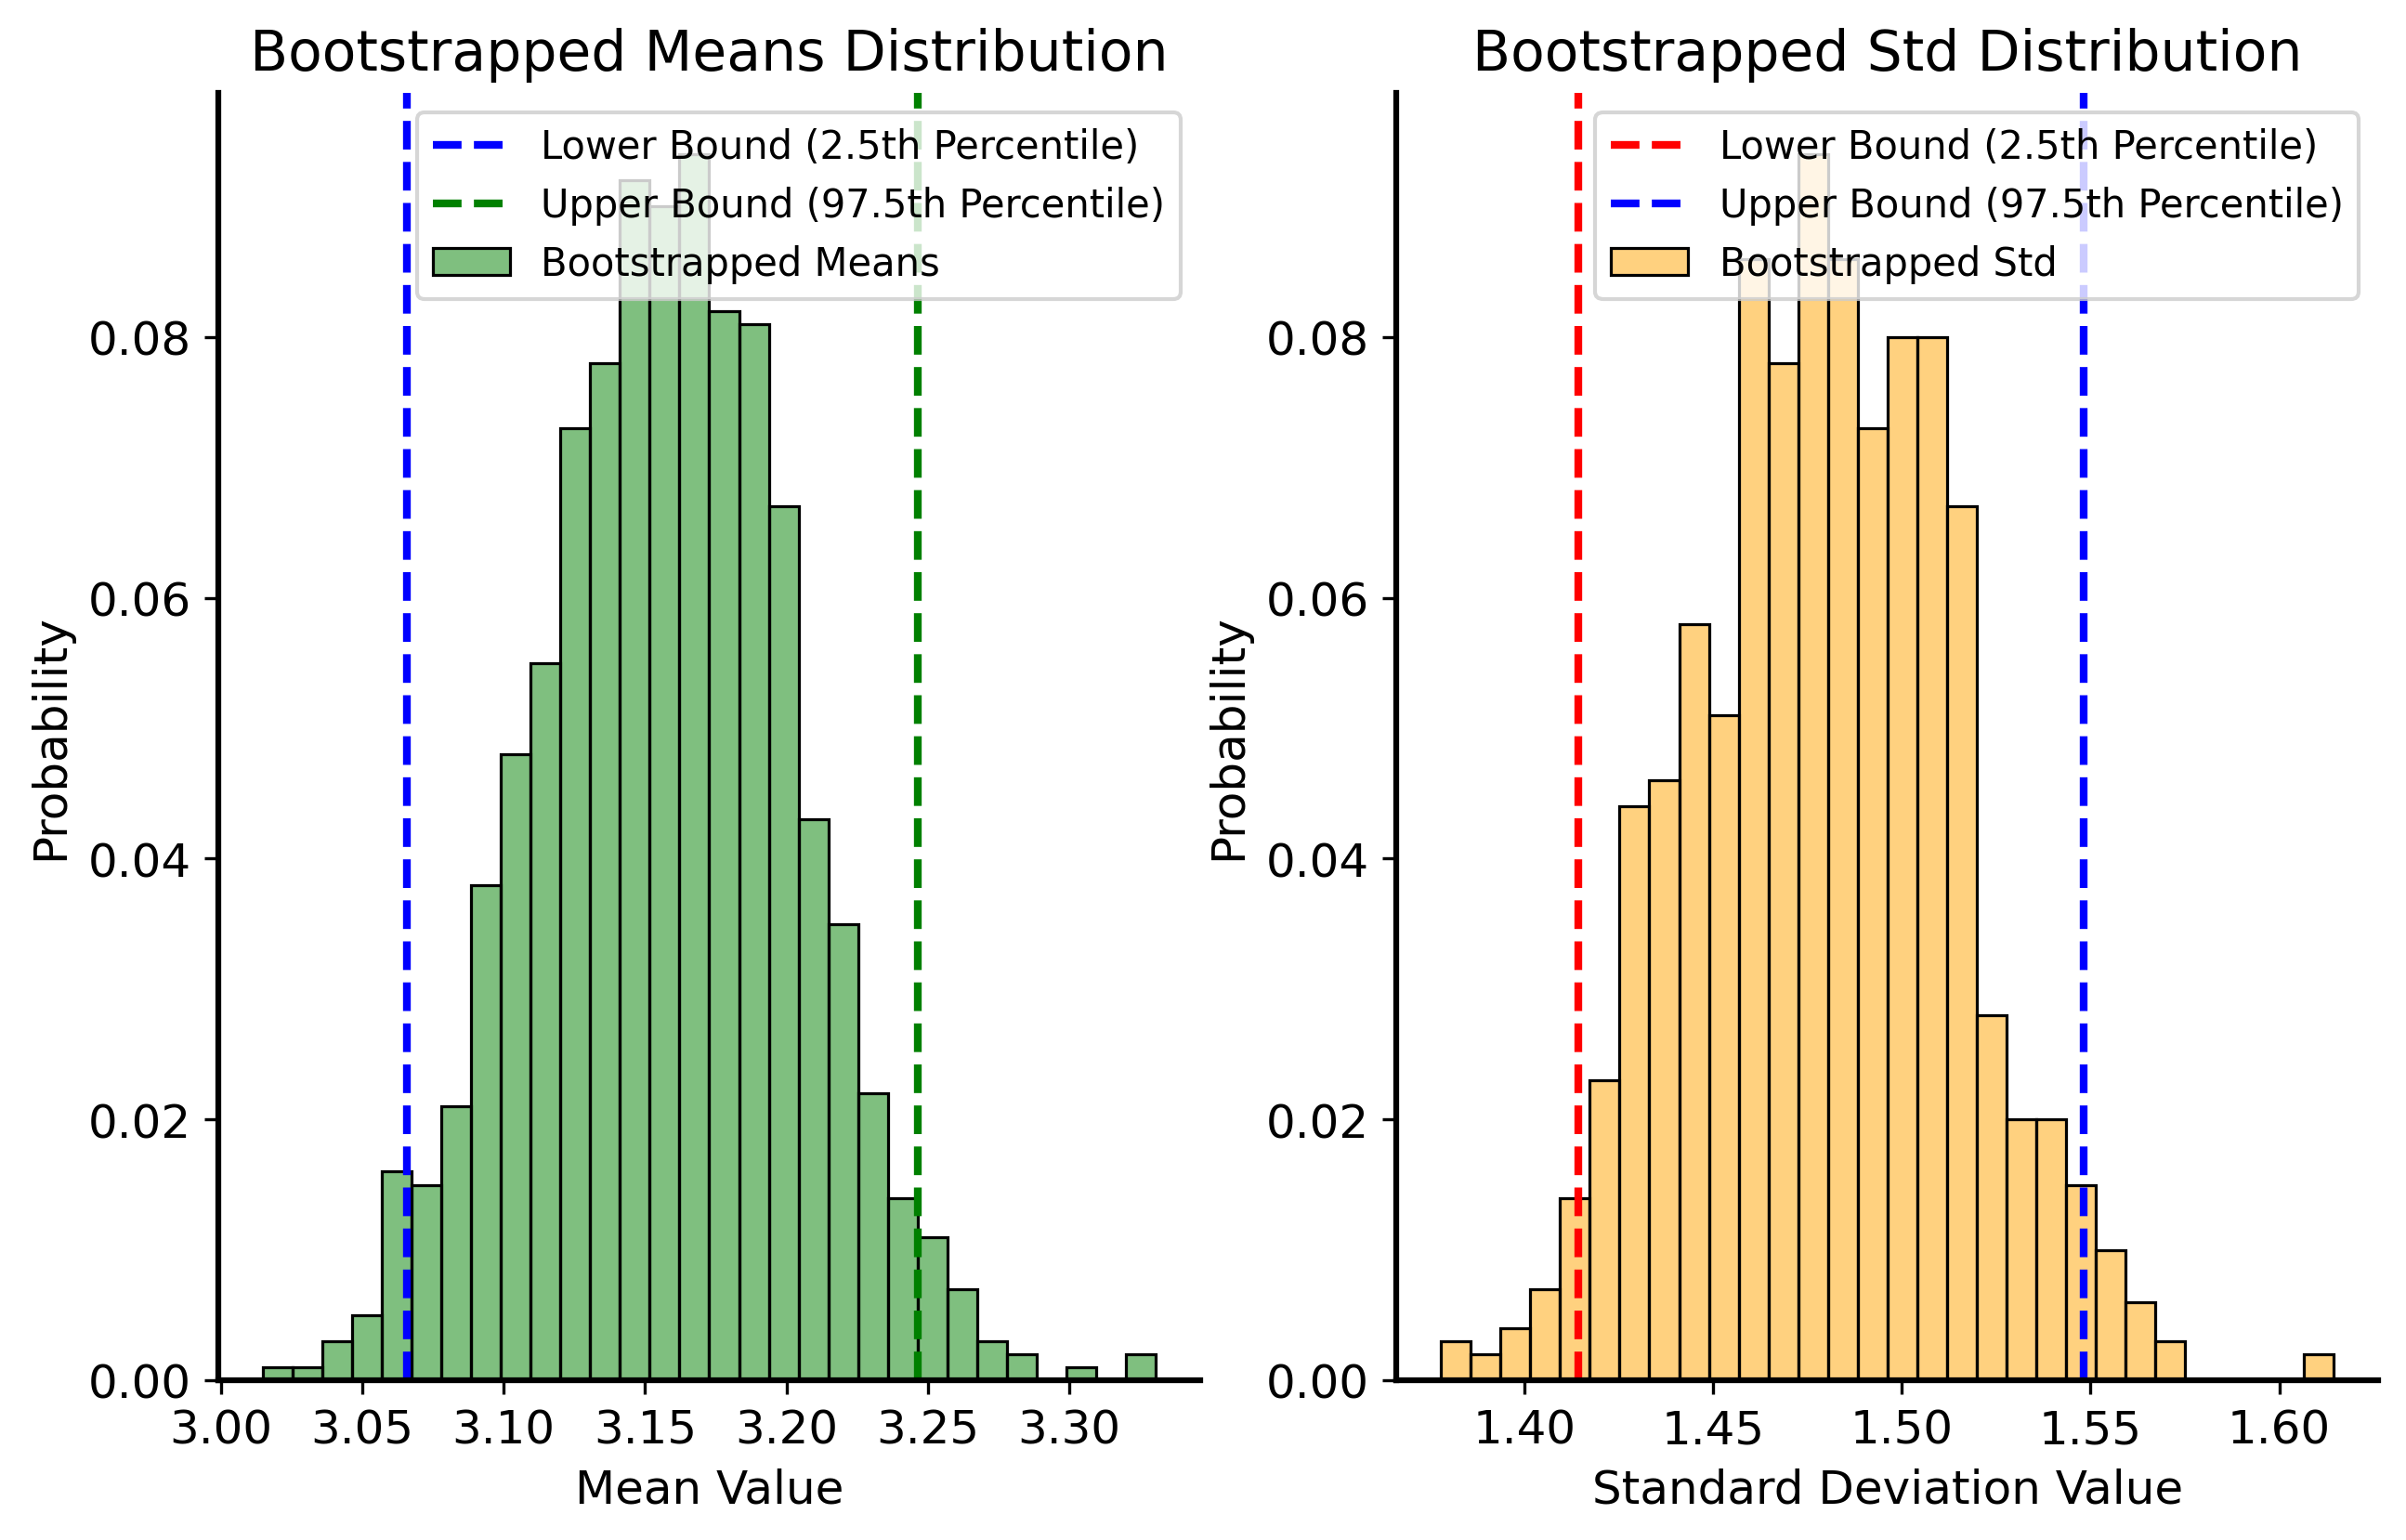

In [51]:
lower_bound_mean = np.percentile(bootstrapped_means, 2.5)
upper_bound_mean = np.percentile(bootstrapped_means, 97.5)
print(f"95% Confidence Interval for the Mean: ({lower_bound_mean:.2f}, {upper_bound_mean:.2f})")
lower_bound_std = np.percentile(bootstrapped_std, 2.5)
upper_bound_std = np.percentile(bootstrapped_std, 97.5)
print(f"95% Confidence Interval for the Standard Deviation: ({lower_bound_std:.2f}, {upper_bound_std:.2f})")

# plot the distribution of bootstrapped means and std with confidence intervals
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
sns.histplot(bootstrapped_means, bins=30, stat="probability", alpha=0.5, color='green', label='Bootstrapped Means', ax=ax[0])
ax[0].axvline(lower_bound_mean, color='blue', linestyle='--', label='Lower Bound (2.5th Percentile)')
ax[0].axvline(upper_bound_mean, color='green', linestyle='--', label='Upper Bound (97.5th Percentile)')
ax[0].set_title("Bootstrapped Means Distribution")
ax[0].set_xlabel("Mean Value")
ax[0].set_ylabel("Probability")
ax[0].legend()

sns.histplot(bootstrapped_std, bins=30, stat="probability", alpha=0.5, color='orange', label='Bootstrapped Std', ax=ax[1])
ax[1].axvline(lower_bound_std, color='red', linestyle='--', label='Lower Bound (2.5th Percentile)')
ax[1].axvline(upper_bound_std, color='blue', linestyle='--', label='Upper Bound (97.5th Percentile)')
ax[1].set_title("Bootstrapped Std Distribution")
ax[1].set_xlabel("Standard Deviation Value")
ax[1].set_ylabel("Probability")
ax[1].legend()
plt.show()

### Understanding the meaning of a confidence interval

The definition of a confidence interval is a bit confusing, but bootstrapping can actually help us demonstrate what it means. 

The *uncertainty* in the confidence interval does **NOT** come from uncertainty in the value of the parameter we are estimating. In our example, we designed the distribution and we know that the true mean is 3.2, so there is no uncertainty about the value of the parameter. The uncertainty comes from the fact that we are estimating the parameter based on a sample, and the sample is not necessarily representative of the population.

To illustrate this, let's repeatedly sample from our distribution and run the bootstrapping procedure on each sample. In the plot below, each interval represents a 95% confidence interval for the mean of a different sample. The highlighted intervals are the ones that failed to capture the true mean of 3.2.

Proportion of CIs that do not contain the true mean: 0.0580


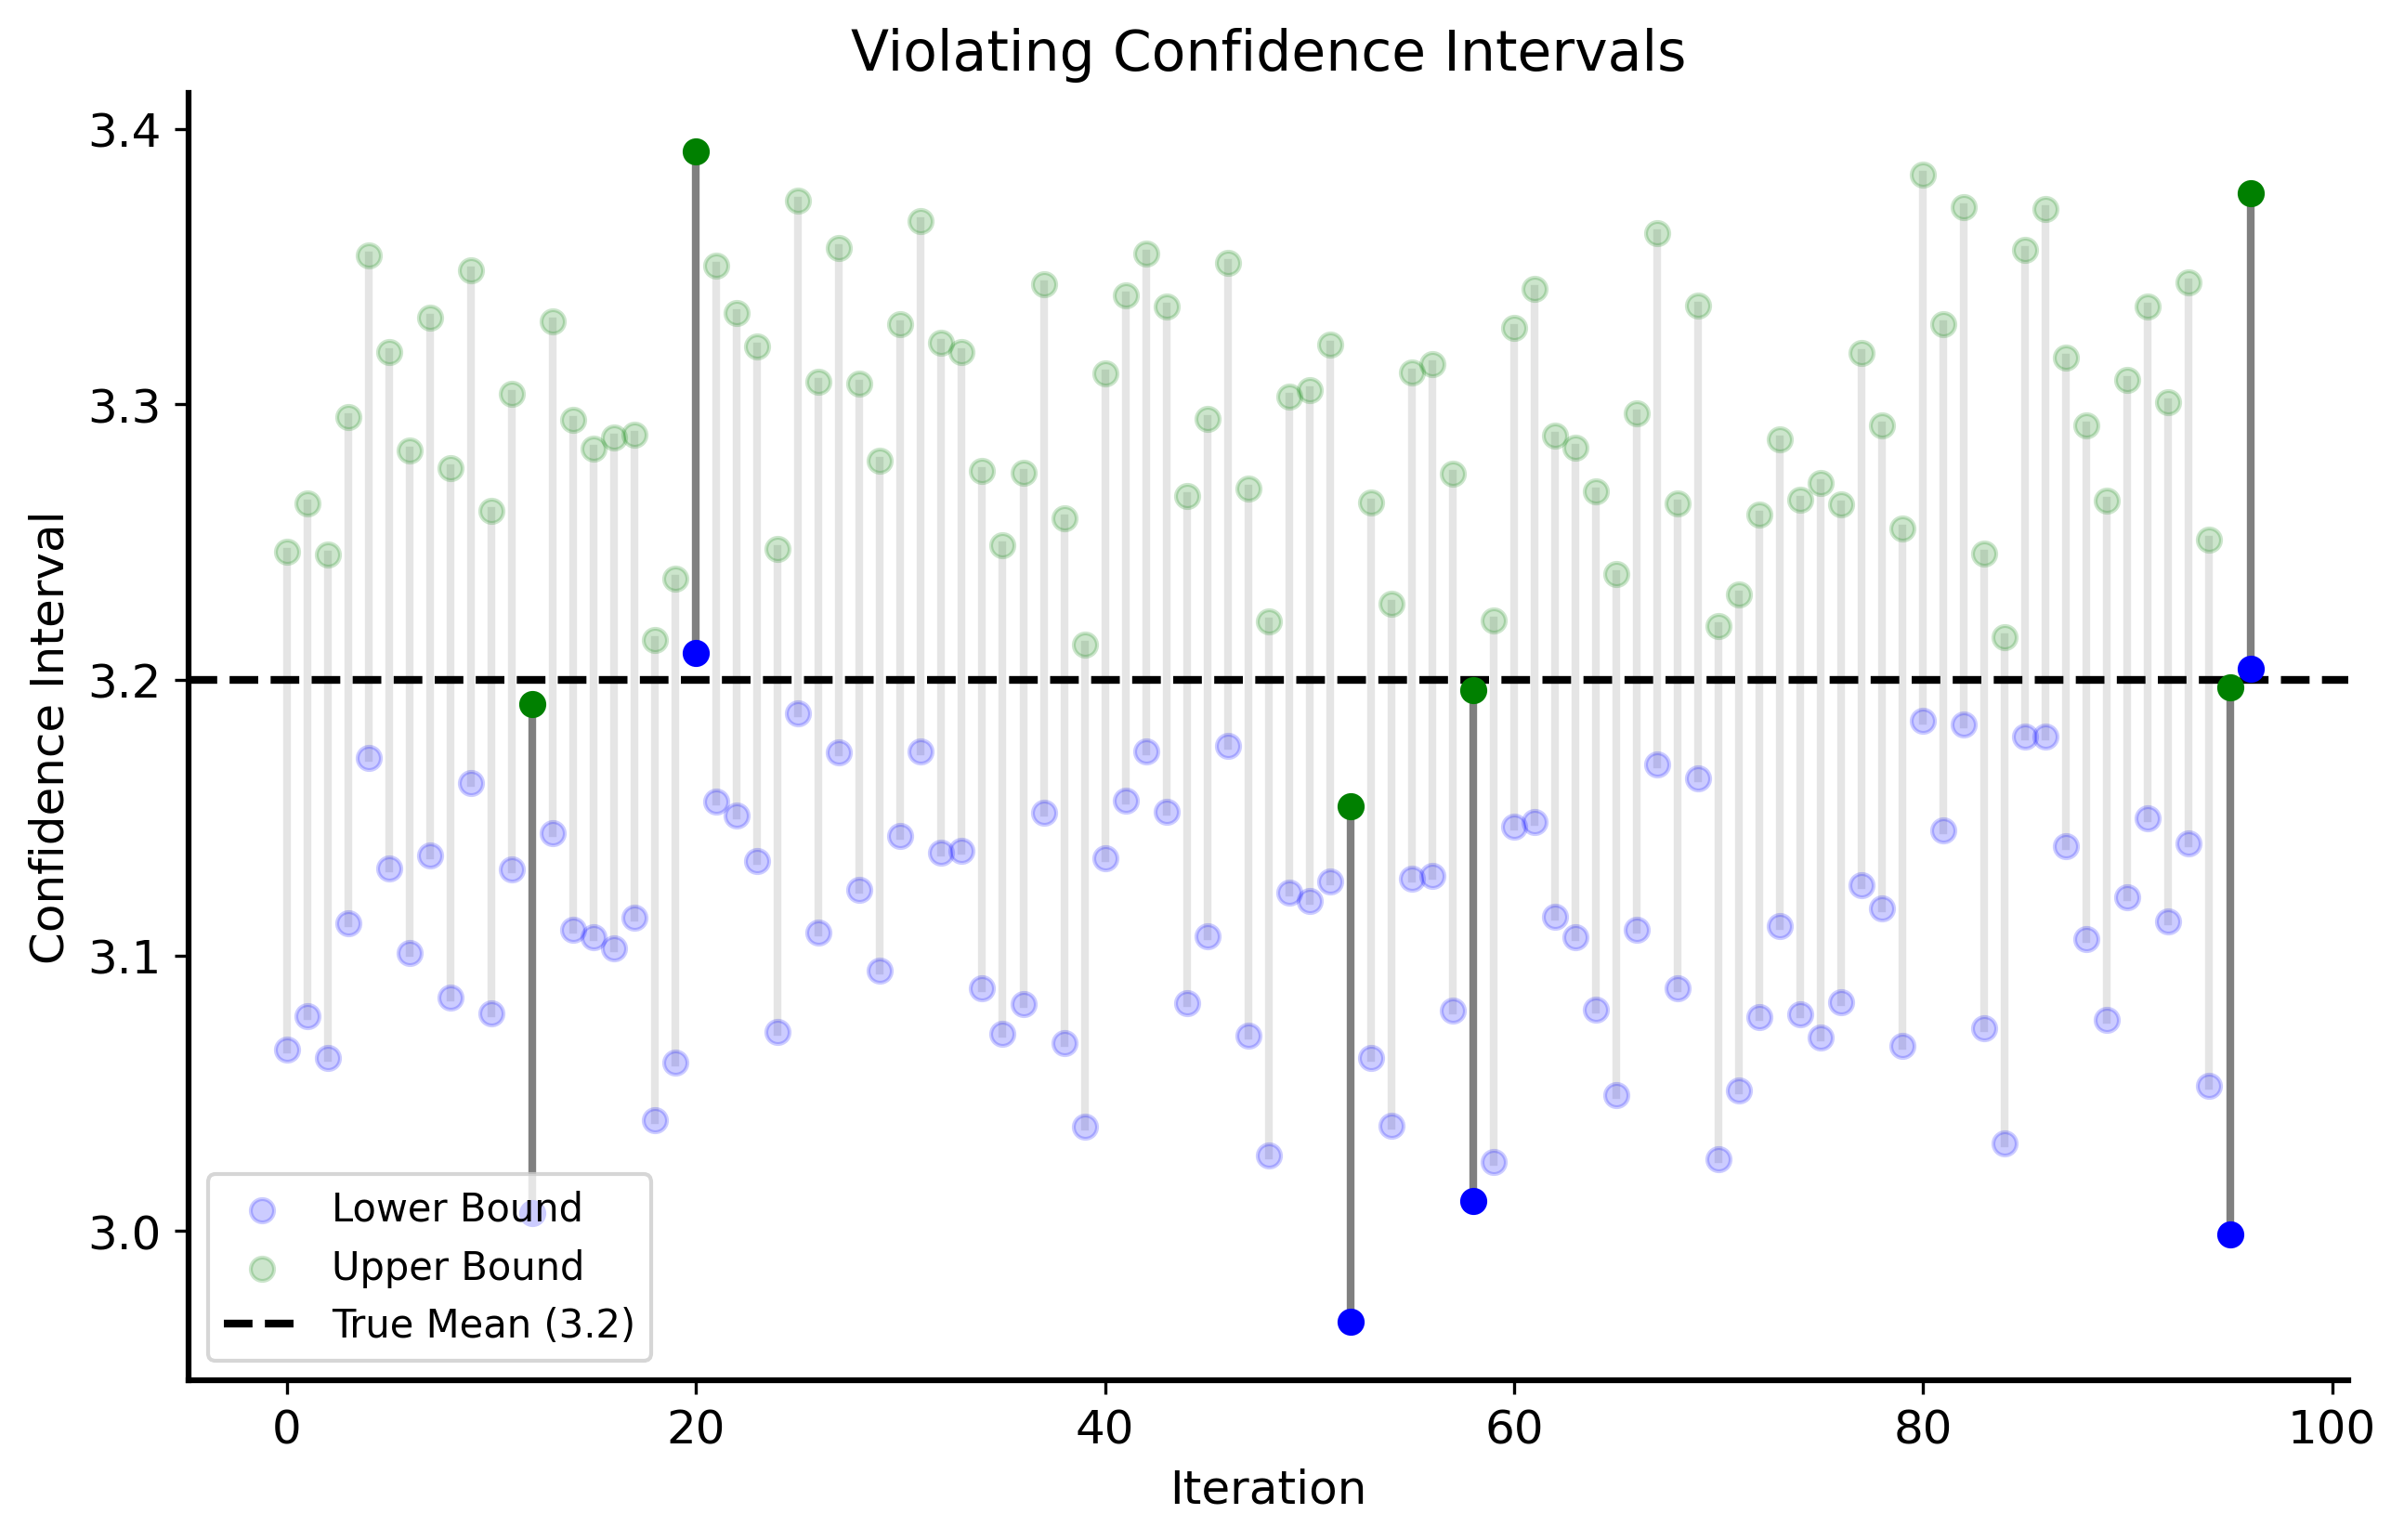

In [76]:
def bootstrap_mean_ci(sample, n_iterations=1000, alpha=0.05, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = len(sample)
    means = []
    for _ in range(n_iterations):
        resample = rng.choice(sample, size=n, replace=True)
        means.append(np.mean(resample))
    lower_bound = np.percentile(means, 100 * alpha / 2)
    upper_bound = np.percentile(means, 100 * (1 - alpha / 2))
    return lower_bound, upper_bound


## Do a bootstrap on 1000 samples from the same distribution, see what proportion of CIs contain the mean
rng = np.random.default_rng(42)
n_sims = 1000
sample_size = 1000
# store the intervals (lower, upper)
ci_list = []
# track which intervals do not contain the true mean
violating_ci_idx = []
for i in range(n_sims):
    sample = rng.normal(loc=3.2, scale=1.5, size=sample_size)
    lower_bound, upper_bound = bootstrap_mean_ci(
        sample, n_iterations=1000, alpha=0.05, rng=rng
    )
    ci_list.append((i, lower_bound, upper_bound))
    # check if the true mean is within the confidence interval
    if not (3.2 >= lower_bound and 3.2 <= upper_bound):
        # print(f"Iteration {i}: CI does not contain the true mean 3.2")
        violating_ci_idx.append(i)
print(
    f"Proportion of CIs that do not contain the true mean: {len(violating_ci_idx) / n_sims:.4f}"
)

# plot the first 5 violating CIs
fig, ax = plt.subplots(figsize=(10, 6))
for i in range(violating_ci_idx[5] + 1):
    if i in violating_ci_idx:
        alpha = 1.0
    else:
        alpha = 0.2
    lower_bound, upper_bound = ci_list[i][1], ci_list[i][2]
    ax.plot([i, i], [lower_bound, upper_bound], color="gray", alpha=alpha, linewidth=2)
    ax.scatter(
        i, lower_bound, color="blue", alpha=alpha, label="Lower Bound" if i == 0 else "", zorder=3
    )
    ax.scatter(
        i,
        upper_bound,
        color="green",
        alpha=alpha,
        label="Upper Bound" if i == 0 else "",
        zorder=3
    )

ax.axhline(3.2, color="black", linestyle="--", label="True Mean (3.2)")
ax.set_title("Violating Confidence Intervals")
ax.set_xlabel("Iteration")
ax.set_ylabel("Confidence Interval")
ax.legend()
plt.show()


Notice that about 5% of the intervals do not capture the true mean, which is exactly what we expect from a 95% confidence interval. 

## Example: variability in scoring average

Let's return to our analysis of NBA players' scoring ability. 

We can use bootstrapping to estimate confidence intervals for each player's scoring average. 

In [ ]:
### Data import and preparation ###
sga_df = pd.read_csv("../data/sga-stats-24-25.csv")
giannis_df = pd.read_csv("../data/giannis-stats-24-25.csv")
# combine the dataframes and clean up the data
sga_df["player"] = "Shai Gilgeous-Alexander"
giannis_df["player"] = "Giannis Antetokounmpo"
compare_df = pd.concat([sga_df, giannis_df], ignore_index=True)
# filter out rows where the player did not play or was inactive
compare_df = compare_df.replace({"Did Not Dress": np.nan, "Inactive": np.nan, "Did Not Play": np.nan, "": np.nan})
compare_df.dropna(subset=["PTS"], inplace=True)
# convert PTS to float/numeric and Date to datetime
compare_df["PTS"] = compare_df["PTS"].astype(float)
compare_df["Date"] = pd.to_datetime(compare_df["Date"])

# print scoring averages
print(f"Shai Gilgeous-Alexander's scoring average: {compare_df[compare_df['player'] == 'Shai Gilgeous-Alexander']['PTS'].mean():.2f}")
print(f"Giannis Antetokounmpo's scoring average: {compare_df[compare_df['player'] == 'Giannis Antetokounmpo']['PTS'].mean():.2f}")

### Bootstrapping confidence intervals for scoring average ###

sga_lower_bound, sga_upper_bound = bootstrap_mean_ci(
    compare_df[compare_df["player"] == "Shai Gilgeous-Alexander"]["PTS"],
    n_iterations=1000,
    alpha=0.05,
    rng=np.random.default_rng(42)
)
giannis_lower_bound, giannis_upper_bound = bootstrap_mean_ci(
    compare_df[compare_df["player"] == "Giannis Antetokounmpo"]["PTS"],
    n_iterations=1000,
    alpha=0.05,
    rng=np.random.default_rng(42)
)
print("-"*25)
print(f"Shai Gilgeous-Alexander's 95% CI: ({sga_lower_bound:.2f}, {sga_upper_bound:.2f})")
print(f"Giannis Antetokounmpo's 95% CI: ({giannis_lower_bound:.2f}, {giannis_upper_bound:.2f})")



Shai Gilgeous-Alexander's scoring average: 32.68
Giannis Antetokounmpo's scoring average: 30.39
-------------------------
Shai Gilgeous-Alexander's 95% CI: (30.97, 34.42)
Giannis Antetokounmpo's 95% CI: (28.70, 32.09)


Notice that Shai's 95% CI does not overlap with Giannis' scoring average, but it does overlap with Giannis' 95% CI!

This actually highlights a problem with our previous analysis: we only considered the variability in SGA's scoring average, and asked how likely it is that his scoring average was equivalent to a specific value (Giannis' scoring average). But we didn't consider the variability in Giannis' scoring average! 

Think about it like this: perhaps SGA's scoring average was randomly higher than expected, and Giannis' scoring average was randomly lower than expected. This possibly makes it more likely that the two averages are closer together than it would appear.

Another way of stating this is that our null hypothesis was too weak (we chose a baseline equal to Giannis' scoring average, but Giannis could actually be better or worse than that). 

Let's fix this mistake! We can use bootstrapping to generate scoring average *distributions* for both players, and then compare the two distributions to see how much they overlap.

The question is: if we resample with replacement from both players' game logs (i.e., their individual game scores), how often do we find that Giannis scores more on average than SGA?

Proportion of bootstrapped samples where Giannis's mean >= SGA's mean: 0.0340


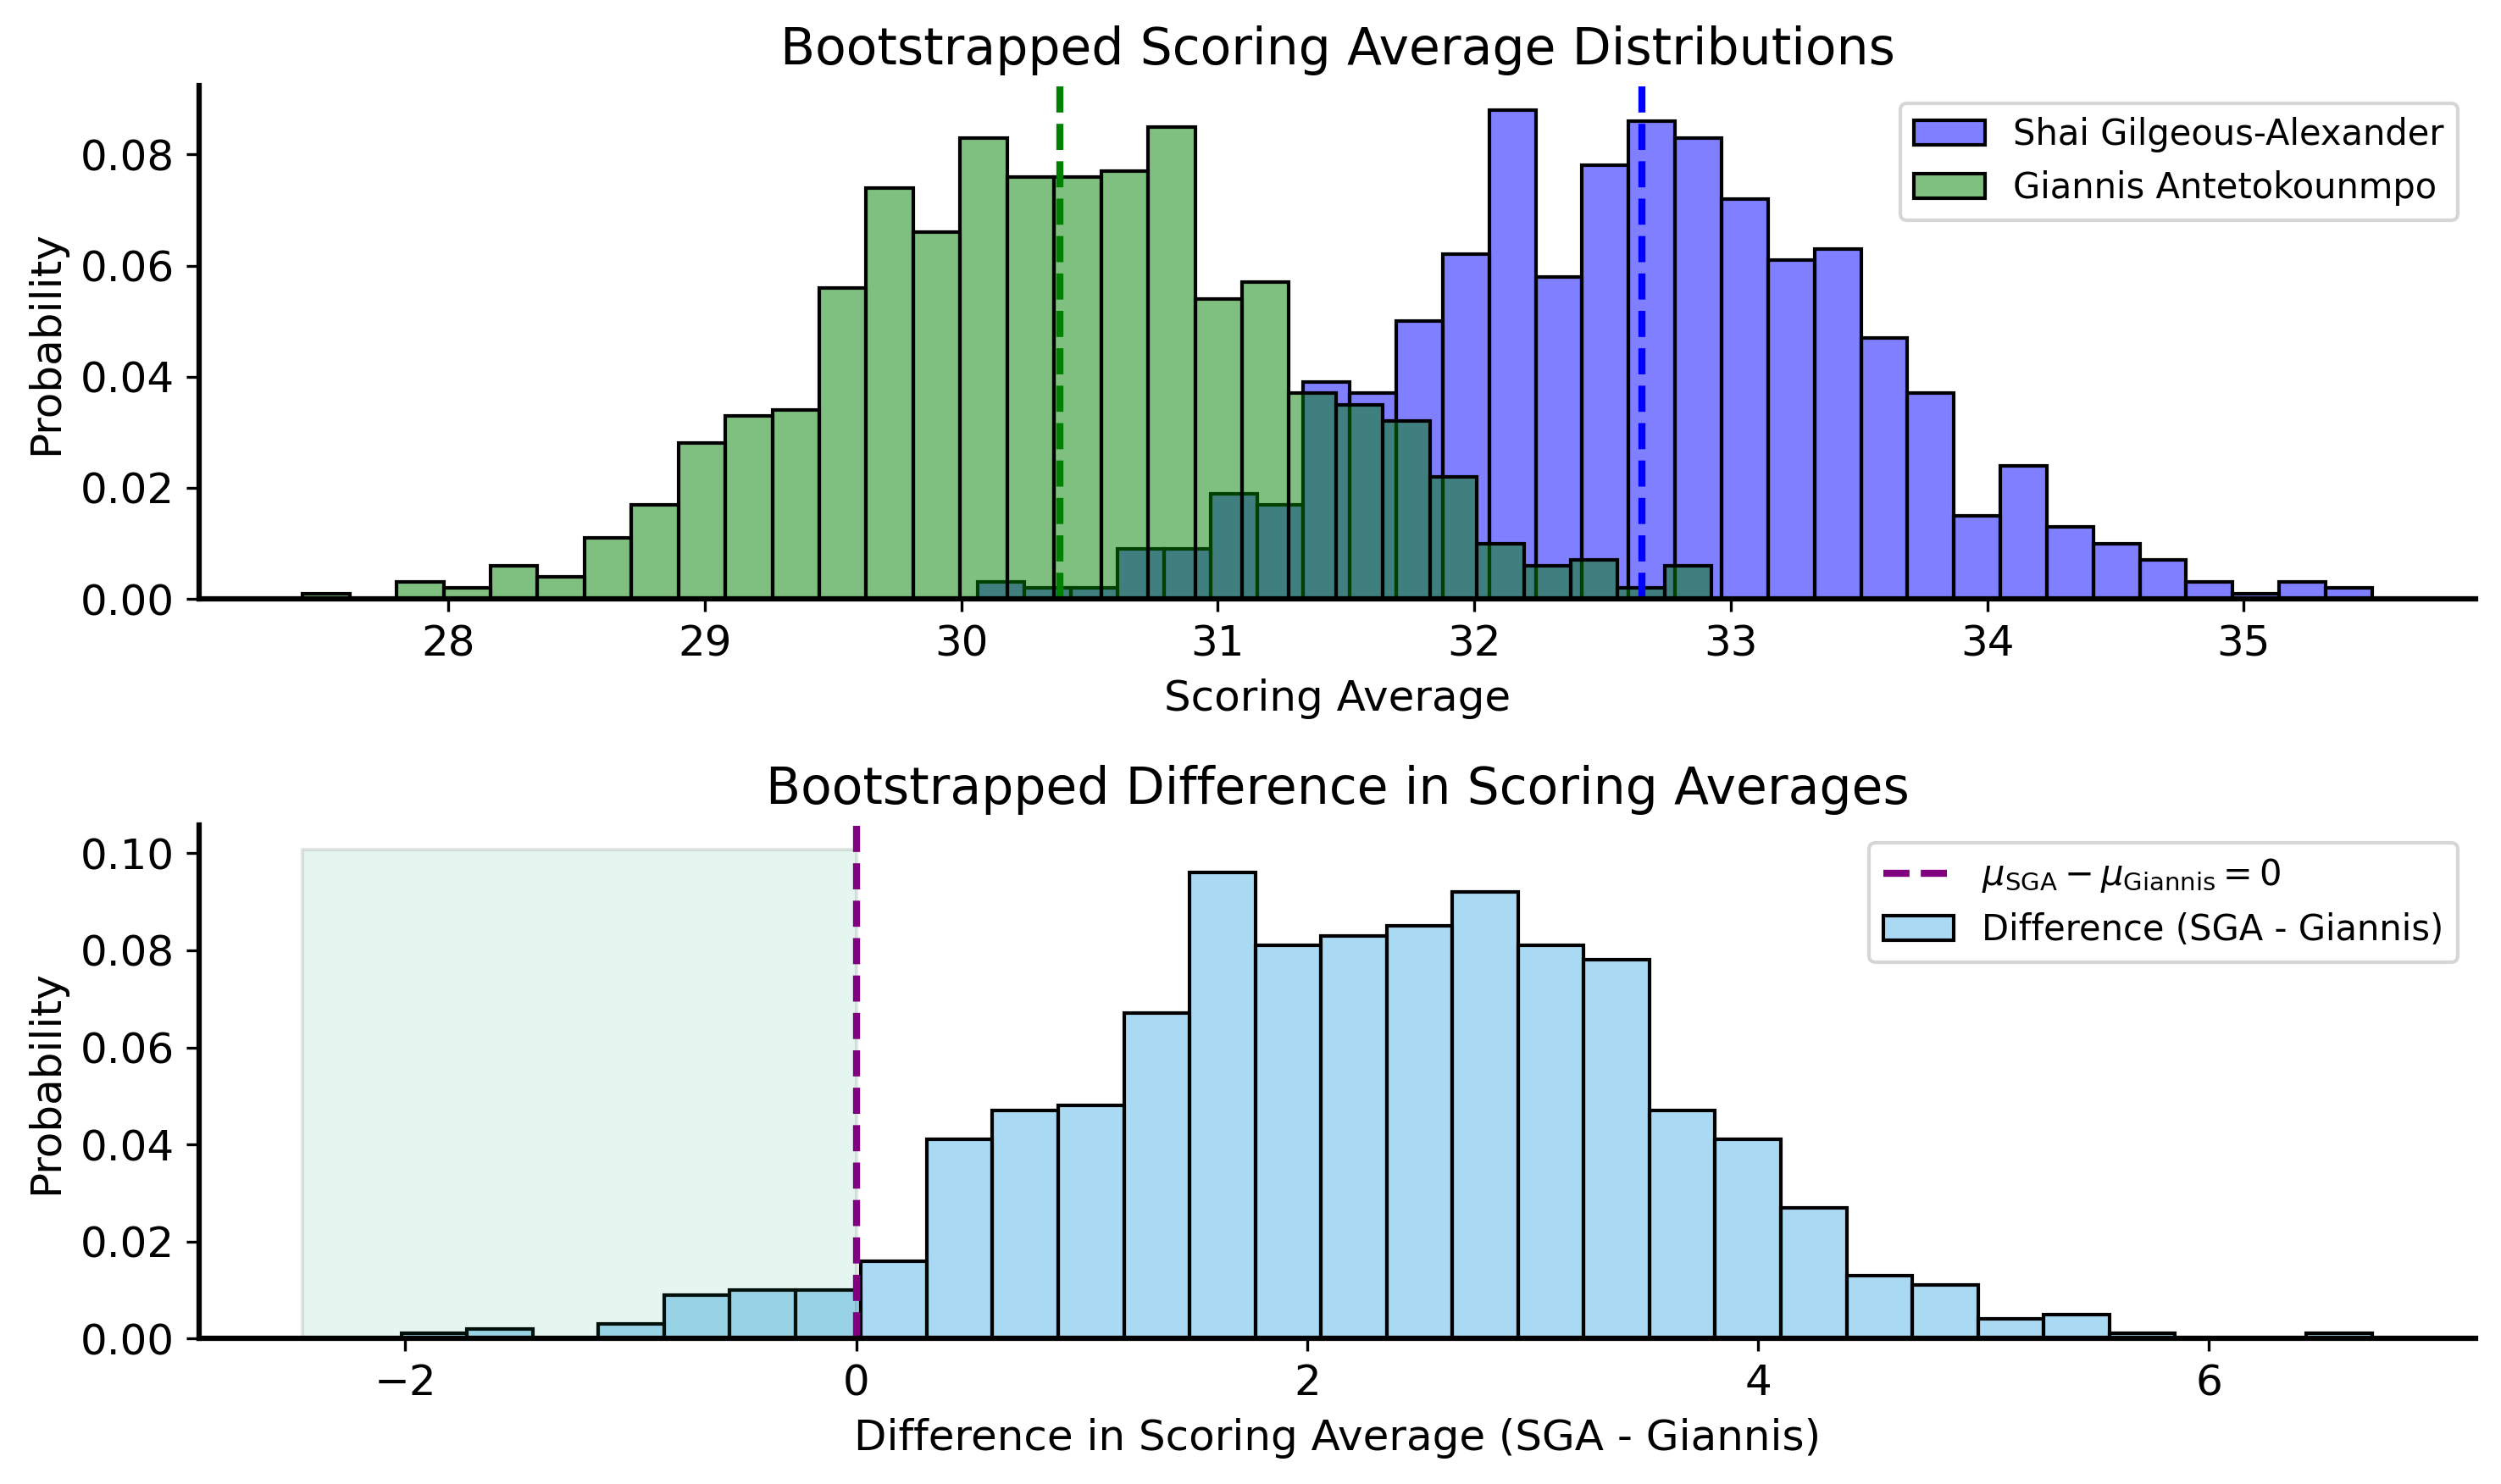

In [94]:
def bootstrap_mean_dist(sample, n_iterations=1000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = len(sample)
    means = []
    for _ in range(n_iterations):
        resample = rng.choice(sample, size=n, replace=True)
        means.append(np.mean(resample))
    return np.array(means)
# Generate bootstrapped distributions for both players
sga_dist = bootstrap_mean_dist(
    compare_df[compare_df["player"] == "Shai Gilgeous-Alexander"]["PTS"],
    n_iterations=1000,
    rng=np.random.default_rng(42)
)
giannis_dist = bootstrap_mean_dist(
    compare_df[compare_df["player"] == "Giannis Antetokounmpo"]["PTS"],
    n_iterations=1000,
    rng=np.random.default_rng(42)
)
# compute the proportion of bootstrapped means where Giannis's mean is greater than or equal to SGA's mean
p_value = np.mean(giannis_dist >= sga_dist)
print(f"Proportion of bootstrapped samples where Giannis's mean >= SGA's mean: {p_value:.4f}")

# Plot the distributions
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
sns.histplot(sga_dist, bins=30, stat="probability", alpha=0.5, color='blue', label='Shai Gilgeous-Alexander', ax=ax[0])
sns.histplot(giannis_dist, bins=30, stat="probability", alpha=0.5, color='green', label='Giannis Antetokounmpo', ax=ax[0])
ax[0].axvline(np.mean(sga_dist), color='blue', linestyle='--')
ax[0].axvline(np.mean(giannis_dist), color='green', linestyle='--')
ax[0].set_title("Bootstrapped Scoring Average Distributions")
ax[0].set_xlabel("Scoring Average")
ax[0].set_ylabel("Probability")
ax[0].legend()
# Plot the distribution of the difference in means
diff_dist = sga_dist - giannis_dist
sns.histplot(diff_dist, bins=30, stat="probability", alpha=0.5, label='Difference (SGA - Giannis)', ax=ax[1])
ax[1].fill_betweenx(
    y=ax[1].get_ylim(),
    x1=ax[1].get_xlim()[0],
    x2=0,
    alpha=0.1
)
ax[1].axvline(0, color='purple', linestyle='--', label=r'$\mu_{\text{SGA}} - \mu_{\text{Giannis}} = 0$')
ax[1].set_title("Bootstrapped Difference in Scoring Averages")
ax[1].set_xlabel("Difference in Scoring Average (SGA - Giannis)")
ax[1].set_ylabel("Probability")
ax[1].legend()

plt.tight_layout()
plt.show()

Recall that in the previous analysis, our $p$-value was 0.004! So our corrected analysis estimates that the probability that SGA's scoring title is a "fluke" is actually an order of magnitude higher.

Another way to look at this is to return to the lens of hypothesis testing. 
What hypothesis test captures the variability of both players' scoring? 
How is our null hypothesis different from the one we used before?

Earlier we just tested if SGA's true scoring rate was higher than a constant value (Giannis' observed scoring average). Now, we are testing if SGA's true scoring rate is higher than Giannis' true scoring rate, which is a random variable that can take on different values across different samples.

- $H_0: ~\mu_{\text{SGA}} \leq \mu_{\text{Giannis}}$
- $H_1: ~\mu_{\text{SGA}} > \mu_{\text{Giannis}}$

This null hypothesis basically posits that in the best case, SGA's scoring average is equal to Giannis' scoring average (if not worse). This would mean that their scoring output is indistinguishable -- if the variance of their scoring is on the same scale, then their game logs are actually being sampled from the same distribution! We can simulate this in a bootstrapping procedure by **combining** the two players' game logs and resampling from the combined distribution. 

The question is: if we resample with replacement from the combined game logs (i.e. the players have the exact same scoring distribution), how often do we see such a large advantage for SGA?

In [98]:
np.random.seed(42)  
# number of games played by each player
n_games_sga = len(compare_df[compare_df["player"] == "Shai Gilgeous-Alexander"])
n_games_giannis = len(compare_df[compare_df["player"] == "Giannis Antetokounmpo"])
# Compute the observed difference in means
observed_diff = (
    compare_df[compare_df["player"] == "Shai Gilgeous-Alexander"]["PTS"].mean()
    - compare_df[compare_df["player"] == "Giannis Antetokounmpo"]["PTS"].mean()
)
print(f"Observed difference in scoring averages: {observed_diff:.2f} (SGA - Giannis)")

n_bootstraps = 1000
bootstrapped_diffs = []
# Perform bootstrapping to compute the difference in means
for i in range(n_bootstraps):
    # Bootstrap sampling for SGA
    sga_sample = compare_df["PTS"].sample(n=n_games_sga, replace=True)
    # Bootstrap sampling for Giannis
    giannis_sample = compare_df["PTS"].sample(n=n_games_giannis, replace=True)
    # Compute the means
    sga_mean = sga_sample.mean()
    giannis_mean = giannis_sample.mean()
    diff = sga_mean - giannis_mean
    bootstrapped_diffs.append(diff)
bootstrapped_diffs = np.array(bootstrapped_diffs)
# Compute the p-value
p_value = np.mean(bootstrapped_diffs >= observed_diff)
print(f"Bootstrapped p-value for the difference in scoring averages: {p_value:.4f}")


Observed difference in scoring averages: 2.30 (SGA - Giannis)
Bootstrapped p-value for the difference in scoring averages: 0.0440


Simulation and resampling methods give us a powerful way to quantify uncertainty in a way that does not rely so heavily on assumptions about the underlying distribution of the data. 

In the next lecture, we'll look at another simulation-based method for hypothesis testing: permutation tests. 